# Predicting House Prices
As my first dive into modeling, my goal for this notebook is to predict house prices based on a Kaggle dataset of house attributes. This analysis will employ a few different models and will also serve as a discussion on strengths and weakness of the models used.

In [2]:
from datetime import datetime
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, normalize
import sklearn.feature_selection as fs
import sklearn.linear_model as lm
from sklearn.metrics import r2_score
from sklearn.decomposition import TruncatedSVD

from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
df = pd.read_csv('train.csv')
Y = df['SalePrice']
df = df.drop(['SalePrice'], axis=1)

## Data Exploration I

Upon doing a quick inspection of the data, I've devised with the following feature handling strategy: 
- variables with less than 20 unique values will be treated as categorical features, with the exception of
    - PoolArea
- the following features have more than 20 distinct values but will be treated as categorical
    - Neighborhood
- the following features have less than 20 unique values, but will more appropriately be treated as continuous features
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - MoSold

In [4]:
not_converted = []
for col in df.columns:
    if (len(df[col].value_counts()) < 20):
        if col != 'PoolArea':
            df[col] = df[col].astype('category')
#             print(col + ' converted to Category')
    else:
        not_converted.append(col)
        
# Categorical variables that have more than 20 distinct values.
df['Neighborhood'] = df['Neighborhood'].astype('category')

# Variables with less than 20 distinct values, that are not categorical. They contain counts, and 
# will be treated as continuous/numeric.
to_convert = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
              'Fireplaces', 'GarageCars', 'YrSold']

for col in to_convert:
    # convert cols back to int. 
    df[col] = df[col].astype(int)
    
# Note to self - think about how to encode the cyclic 'month' variable

Observations: 
   - The variables that are approximately normally distributed or have a skew, tend to be related to square footage.
   - There are a handful of discrete numerical variables representing counts
   - There are about 9 variables that look like they have a very low variability in information ie. have a high percentage of one value.    

## Data Cleaning


### High percentage of NAs

Identifying variables with more than some percentage of NAs

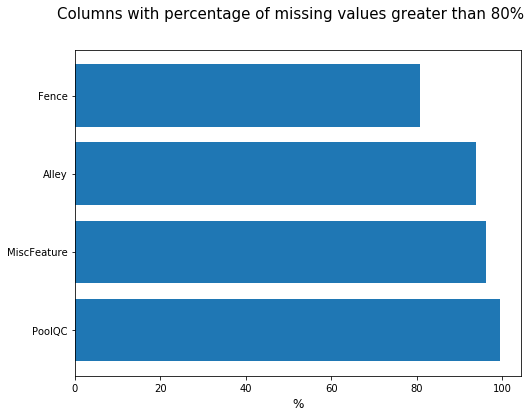

In [5]:
thresh = .8
nulls = df.isna().sum()

fig = plt.figure(figsize=(8, 6))
plt.barh(nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False).index, 
         (nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False)/df.shape[0]*100).values)
fig.suptitle('Columns with percentage of missing values greater than 80%', fontsize=15)
plt.xlabel('%', fontsize=12)
plt.show();

This plot suggests we should drop Alley, PoolQC, Fence, MiscFeature because they are over 80% null.
Upon looking at the data dict however, you'll see that the NAs represent the case where a house does not have a given feature, and are not actually `nulls`. 
Let this be a reminder to understand what the data represents.

### Fill missing values

In [6]:
# Separate out columns by data type to fill in missing values
integer_columns = df.select_dtypes(include=[np.int64, np.float64])
categorical_columns = df[df.select_dtypes(include=['category']).columns.union(['Id'])]

In [7]:
# Interpolate two fields using linear interpolation
integer_columns = integer_columns.interpolate()

In [8]:
# Handling the two fields where the NaNs do not correspond to a known value.
# Fields 'Electrical' and "MasVnrType" have 8 and 1 missing values respectively. Since these are two fields
# where the NaN does not correspond to a value, and since there are so few records, we're dropping those.
categorical_columns = categorical_columns[~categorical_columns['Electrical'].isna()]
categorical_columns = categorical_columns[~categorical_columns['MasVnrType'].isna()]

# adding 'None' category to categorical fields, and then replacing NaN with 'None' so the records can be used in models
def add_category(df, col):
    df[col].cat.add_categories('None', inplace=True)

null_categorical = categorical_columns.isna().sum().sort_values(ascending=False).reset_index()
null_categorical = null_categorical[null_categorical['index'] != 'Id']
for index, row in null_categorical.iterrows():
    if row[0] > 0:
        add_category(categorical_columns, row['index'])
        categorical_columns[row['index']] = categorical_columns[row['index']].fillna(value='None')

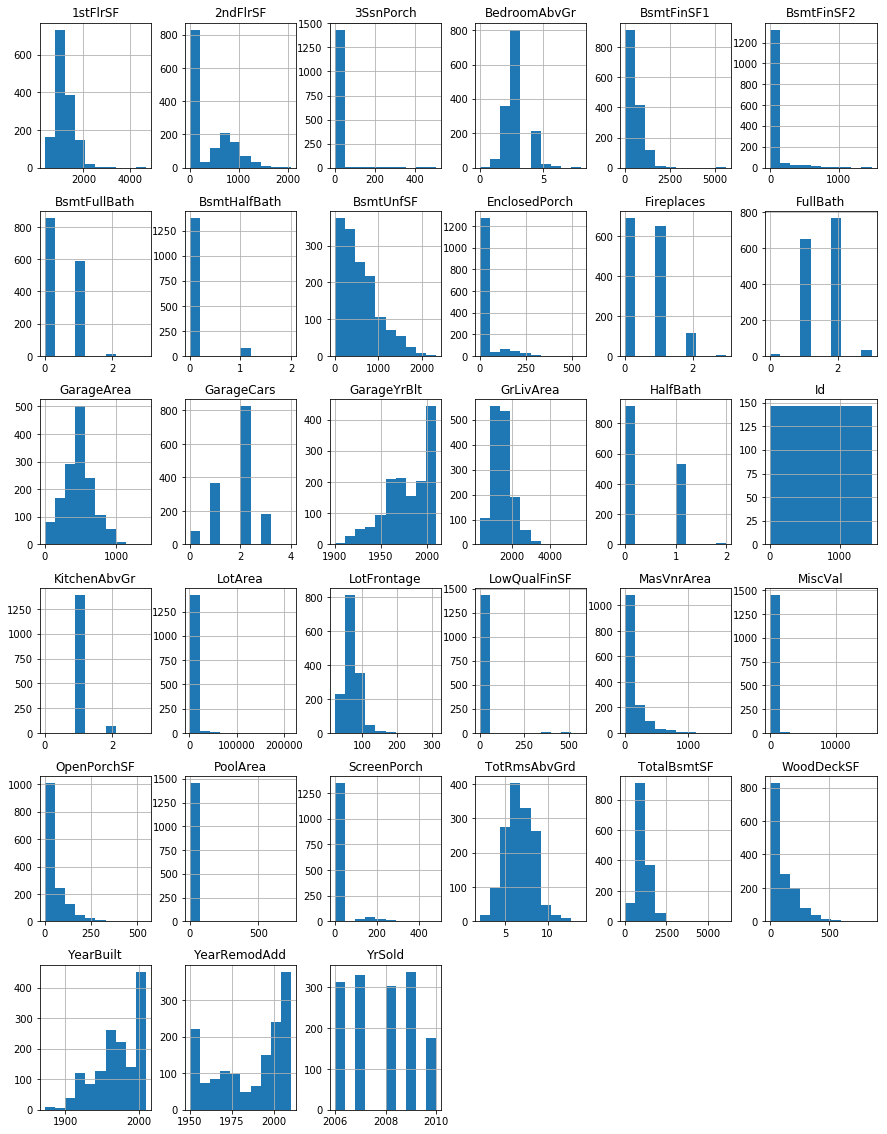

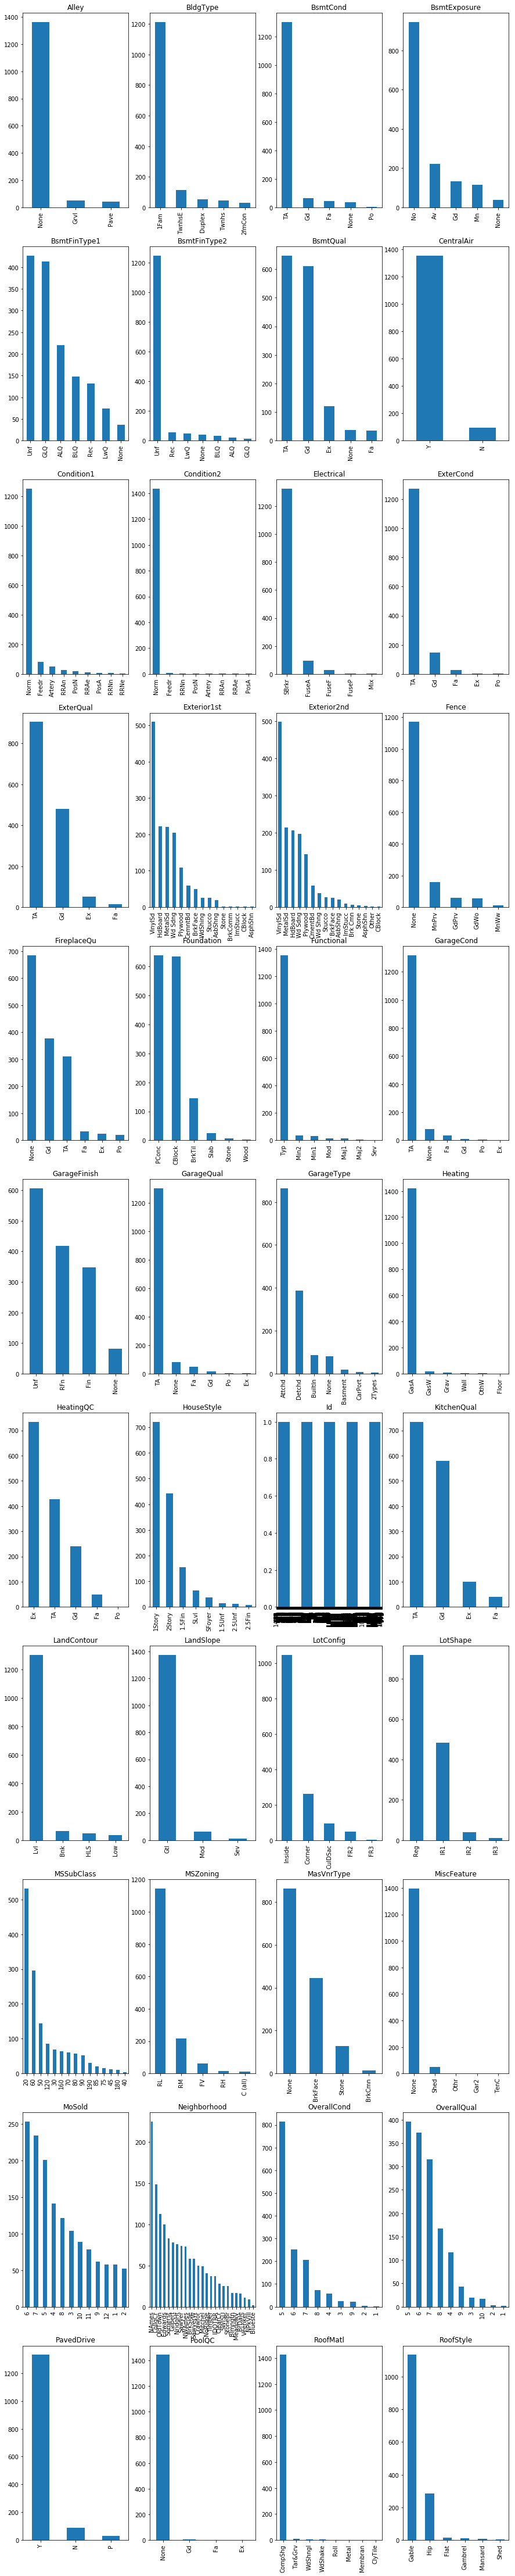

In [9]:
# plot the numerical variables
_ = integer_columns.hist(bins=10, figsize=(15, 20))

# plot the categorical variables

try:
    fig, ax = plt.subplots(11, 4)
    for i, cat in enumerate(categorical_columns.columns):
        _ = categorical_columns[cat].value_counts().plot('bar', ax=ax[i//4][i % 4], figsize=(15, 80)).set_title(cat);
    plt.show();
except IndexError:
    pass

In [10]:
processed_df = integer_columns.join(categorical_columns.set_index('Id'), on='Id').drop(['Id'], axis=1)

### Split data into Train, Test, Validation

In [11]:
X = pd.get_dummies(processed_df, drop_first=True)

In [12]:
train_pct=.7
validation_pct = .333

shuffled = np.random.permutation(X.index)

train_idx = shuffled[:int(np.round(train_pct*len(shuffled)))]
test_val_idx = shuffled[int(np.round(train_pct*len(shuffled))):]

test_idx = test_val_idx[:int(np.round(validation_pct*len(test_val_idx)))]
val_idx = test_val_idx[int(np.round(validation_pct*len(test_val_idx))):]

train_X, train_Y = X.iloc[train_idx], Y.iloc[train_idx]
test_X, test_Y = X.iloc[test_idx], Y.iloc[test_idx]
val_X, val_Y = X.iloc[val_idx], Y.iloc[val_idx]

print("Have we retained all records? ", len(train_X) + len(test_X) + len(val_X) == len(X))
print("Are all the datasets distinct? ", "Yes" if len(set(test_X.index).intersection(set(val_X.index))) == 0 else "No")

Have we retained all records?  True
Are all the datasets distinct?  Yes


### Predicting with linear models

In [13]:
# perform standardization of the data
# Center the data so the mean = 0, and stdev = 1
scalar = StandardScaler()
X_standardized = scalar.fit_transform(train_X)

# normalizing using the L2 norm 
X_scaled = normalize(X_standardized, norm='l2')

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
# fit linear regression on X (original with dummy variables for categorical)
reg_lm_raw = lm.LinearRegression().fit(train_X, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_lm_raw.score(train_X, train_Y), '\n')

# fit linear regression on standardized and normalized data
reg_lm_scaled = lm.LinearRegression().fit(X_scaled, train_Y)
print('Prediction score of simple linear regression on scaled and normalized data: ', reg_lm_scaled.score(X_scaled, train_Y))

Prediction score of simple linear regression on raw data:  0.9389086421687003 

Prediction score of simple linear regression on scaled and normalized data:  0.9209694569670975


Scaling and normalizing the data did not yield a better prediction accuracy for the simple linear regression, but will be necessary for additional models used below. We'll primarily use X_scaled going forward.

These regression models have used the full input feature-set, and have likely overfit the data. I'll show this to be true below.

In [15]:
# Lasso Regression | L1 norm aka sum(abs(Beta)). Regularizes the loss with lambda*sum(abs(Beta))
reg_lasso = lm.Lasso(alpha=5, 
                     fit_intercept=True, 
                     normalize=False, 
                     max_iter=10000
                    )\
              .fit(X_scaled, train_Y)

reg_lasso.score(X_scaled, train_Y)

0.9111396180060293

This model achieved a similar R^2 to the simple linear regression with just an alpha of 0.5. I chose to use a LASSO to be able to make a prediction while also having some meaningful understanding of which house attributes provide a contribution to the eventual sale price. Let's get a sense of how many input features can be dropped while still maintaining an acceptable model performance.

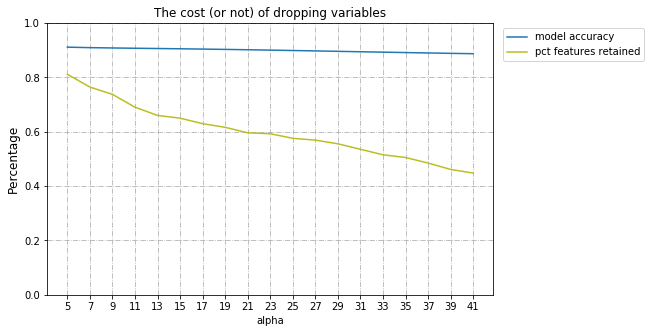

In [16]:
regressions = []
scores = []
alphas = np.arange(5, 42, 2)

for a in alphas:
    regression = lm.Lasso(alpha=a, 
                          fit_intercept=True, 
                          normalize=False, 
                          max_iter=10000
                         )\
                   .fit(X_scaled, train_Y)
    regressions.append(regression)
    scores.append(regression.score(X_scaled, train_Y))

# plt.figure()
fig, ax = plt.subplots(figsize=(8, 5))
color = 'tab:blue'
line1 = ax.plot(alphas, scores, color=color, label='model accuracy')
plt.xticks(alphas)
plt.grid(True, linestyle='-.')
plt.xlabel('alpha')
plt.ylim([0, 1])
plt.ylabel('Percentage', color='black', size=12)
plt.title('The cost (or not) of dropping variables')

# collections.Counter returns dict with counts of each value in list. Using to get counts of 0
coefs = [collections.Counter(x.coef_)[0]/len(x.coef_) for x in regressions]

color = 'tab:olive'
line2 = ax.plot(alphas, 1 - np.array(coefs), color=color, label='pct features retained')
# plt2.set_ylabel('Fraction of features retained', color=color, size=12)
plt.legend(bbox_to_anchor=(1.01,1))
plt.show();

This plot shows that a penalty factor of <i>alpha</i> = 41 which drops about 50% of the input features would cost a {{ np.round((scores[-1] - scores[0]) * 100, 2) }} percentage point drop in accuracy. Let's use this hyper parameter tuning to test our models on the test set.

In [18]:
# Lasso Regression with alpha=19
a = 41
reg_lasso_41 = lm.Lasso(alpha=a, fit_intercept=True, normalize=False, max_iter=10000).fit(X_scaled, train_Y)
reg_lasso_41.score(X_scaled, train_Y)

0.8870102216606564

### Evaluate generalizability of lasso and simple linear regression

In [19]:
test_X_scaled = scalar.transform(test_X)
test_X_processed = normalize(test_X_scaled, norm='l2')

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [20]:
model_performance = pd.DataFrame(data={'model': ['OLS', 'OLS', 'LASSO-41'], 
                   'data':['raw, unprocessed data', 'standardized and normalized data', 'standardized and normalized data'],
                   'R**2': [reg_lm_raw.score(test_X, test_Y), reg_lm_scaled.score(test_X_processed, test_Y),reg_lasso_41.score(test_X_processed, test_Y)]
                  })

In [21]:
model_performance

,model,data,R**2
0,OLS,"raw, unprocessed data",6.131476e-01
1,OLS,standardized and normalized data,-3.174341e+21
2,LASSO-41,standardized and normalized data,7.711921e-01


Since the R^2 value of the linear regression makes no sense, performed on the scaled test set appears to have suffered more of a performance hit than the LASSO analysis, which dropped 50% of the input features. 

### Singular Value Decomposition

This section will explore using SVD as a method to perform dimensionality reduction on the data and using the resulting components as inputs to a linear regression.

In [50]:
n_components = 50

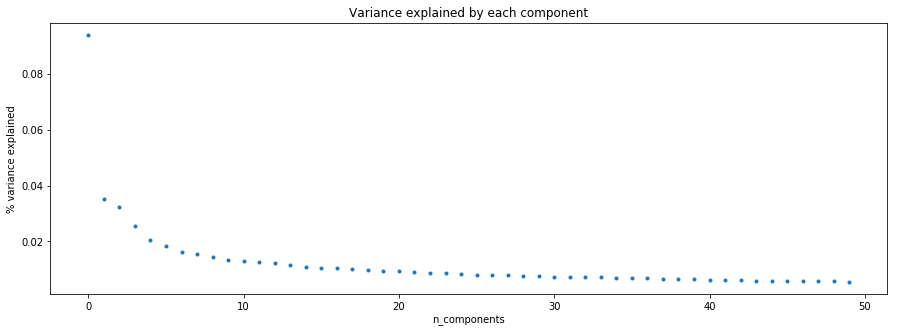

In [63]:
SVD = TruncatedSVD(n_components=n_components, algorithm='randomized', random_state=7)
SVD.fit(X_scaled)
X_SVD_transformed = SVD.transform(X_scaled)
plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.plot(range(n_components), SVD.explained_variance_ratio_, '.')
plt.title('Variance explained by each component')
plt.xlabel('n_components')
plt.ylabel('% variance explained')
plt.show();

In [80]:
# fit linear regression on first 10 components given by the SVD's singular values.
SVD_10 = pd.DataFrame(X_SVD_transformed).iloc[:,0:11]
reg_SVD = lm.LinearRegression().fit(SVD_10, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_SVD.score(SVD_10, train_Y))


Prediction score of simple linear regression on raw data:  0.7148069124726673


Interestingly, the first 10 components explain only {{ np.round(sum(SVD.explained_variance_ratio_[:11]) * 100, 2) }}% of the variance in the data, yet yield a model accuracy of {{ reg_SVD.score(SVD_10, train_Y) }}.

I'll include another 10 components to see if that will improve model performance.

In [81]:
SVD_20 = pd.DataFrame(X_SVD_transformed).iloc[:,0:21]
reg_SVD_20 = lm.LinearRegression().fit(SVD_20, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_SVD_20.score(SVD_20, train_Y))


Prediction score of simple linear regression on raw data:  0.7385516801060901


# Future work: TBD

- elasticnet
- gradient boosting
- neural net

In [ ]:
# Elasticnet: uses both the Ridge and Lasso penalties. Drawback of Lasso is that if there are a number of correlated 
# variables, it will only select one, and deselect for the rest. 

\begin{equation*}
{\hat {\beta }}\equiv {\underset {\beta }{\operatorname {argmin} }}(\|y-X\beta \|^{2}+\lambda _{2}\|\beta \|^2_2+\lambda _{1}\|\beta \|_{1})
\end{equation*}

scikit-learn's elasticnet implementation allows you to attribute weights (which sum to 1) to each of the penalties. Setting $l1_{ratio} = 1 $ will apply the Lasso, or $L1$ norm, penalty and setting $l1_{ratio} = 0$ will apply the Ridge, or $L2$ norm penalty. When $0 < l1_{ratio} < 1$ will apply some fraction of both penalties. The following is the objective function the implementation aims to minimize

\begin{equation*}
{\frac{1}{2*n_{samples}} * ||y - X\beta||^2_2
+ \alpha * l1_{ratio} * ||\beta||_1
+ 0.5 * \alpha * (1 - l1_{ratio}) * ||\beta||^2_2}
\end{equation*}